In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
from tqdm import tqdm, trange
from classy import Class



from utils import *
from massfunction import *


import math
import torch
import gpytorch
from matplotlib import pyplot as pl
from emulator import *

In [2]:
emulator = AemulusNu_HMF_Emulator()

In [3]:
#Plank 2018
cosmology = {'10^9 As':2.09681,
            'ns': 0.9652,
            'H0': 67.37,
            'w0': -1,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'nu_mass_ev': 0.07071068,
            'sigma8': 0.8101,
            }

In [4]:
M = 10**np.linspace(13, 17, 100)
dndM = []
for m in tqdm(M):
    dndM += [emulator.predict(cosmology,0, m)]

  0%|          | 0/100 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(lambda k: dσ2dk(k, R, pk), 0, 20/R, limit=1000)
/home/users/delon/aemulusnu_massfunction/utils.py:59: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(lambda k: dσ2dRdk(k, R, pk), 0, 20/R, limit=1000)
100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


In [ ]:
for i in range(1):
    dndM = np.vectorize()

(1e-61, 1e-16)

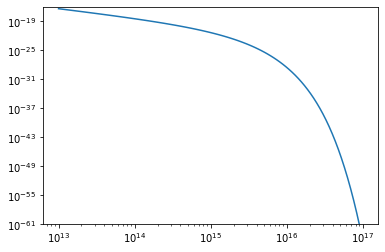

In [5]:
plt.plot(M, dndM)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-61, 1e-16)